# Final Capstone

# Project Title: TalkingData User Demographics

### In this project the data collected by TalkingData, China’s largest third-party mobile data platform, will be used. The data set can be found on kaggle website link bellow:
https://www.kaggle.com/c/talkingdata-mobile-user-demographics
### TalkingData is seeking to leverage behavioral data from more than 70% of the 500 million mobile devices active daily in China to help its clients better understand and interact with their audiences. The datas set will be used to build a model predicting users’ demographic characteristics based on their app usage, geolocation, and mobile device properties.
### File descriptions:
<br>gender_age_train.csv: the train set
<br> gender_age_test.csv: the test set
<br> events.csv: when a user uses TalkingData SDK, the event gets logged in this data. Each event has an event id, location (lat/long)
<br> app_events.csv: the event corresponds to a list of apps in app_events.
<br> app_labels.csv: apps and their labels, the label_id's can be used to join with label_categories
<br> label_categories.csv: apps' labels and their categories in text
<br> phone_brand_device_model.csv: device ids, brand, and models 

### Notes:
<br> 'group' in gender_age_train.csv areage groups which is the target variable we are going to predict
<br> 'timestamp' in events.csv referrs to when the user is using an app with TalkingData SDK
<br> 'phone_brands' in phone_brand_device_model.csv are in Chinese

### Project Goal:
<br> Given the data set, the gender, age, type of device, and which phone brand used by a user will be used in order to accurately classify and predict the age range and gender of that individual.

In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from time import perf_counter


C:\Users\Fazel\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Read information from csv files
gender_age_train = pd.read_csv("../Fazel/talkingdata-mobile-user-demographics/gender_age_train.csv")
gender_age_test = pd.read_csv("../Fazel/talkingdata-mobile-user-demographics/gender_age_test.csv")
events = pd.read_csv("../Fazel/talkingdata-mobile-user-demographics/events.csv")
app_events = pd.read_csv("../Fazel/talkingdata-mobile-user-demographics/app_events.csv")
app_labels = pd.read_csv("../Fazel/talkingdata-mobile-user-demographics/app_labels.csv")
label_categories = pd.read_csv("../Fazel/talkingdata-mobile-user-demographics/label_categories.csv")
phone_brand_device_model = pd.read_csv("../Fazel/talkingdata-mobile-user-demographics/phone_brand_device_model.csv")

# Exploratory Data Analysis

In [3]:
print(gender_age_train.shape)
gender_age_train.head()

(74645, 4)


,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


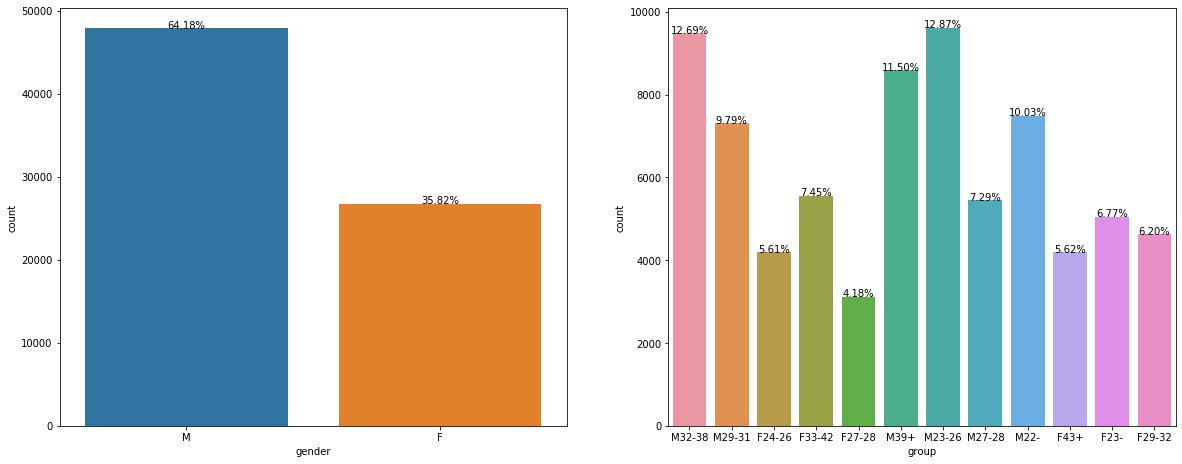

In [9]:
select_categoric = ['gender', 'group']
total_records= len(gender_age_train)
plt.figure(figsize=(20,2))
j=0
for i in select_categoric:
    j +=1
    plt.subplot(1,2,j)
    ax1 = sns.countplot(data=gender_age_train, x= i)
    if(j==8 or j== 7):
        plt.xticks( rotation=90)
    for p in ax1.patches:
        height = p.get_height()
        ax1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format((height/total_records)*100,0),
                ha="center",rotation=0) 
plt.subplots_adjust(bottom=-0.9, top=2)
plt.show()

In [33]:
# Check numerical value of age groups
gender_age_train.group.value_counts()

M23-26    9605
M32-38    9476
M39+      8581
M22-      7488
M29-31    7309
F33-42    5561
M27-28    5445
F23-      5050
F29-32    4628
F43+      4194
F24-26    4190
F27-28    3118
Name: group, dtype: int64

The graphs of the two most iterested variables for our prediction models show that the percentage of male users is pretty higher than female users, and young male users are the most of all users. Because the age groups contain deferent amount of users, and it will be our target variable in the prediction models, we will need to balance the dataset to avoid overfitting our models.

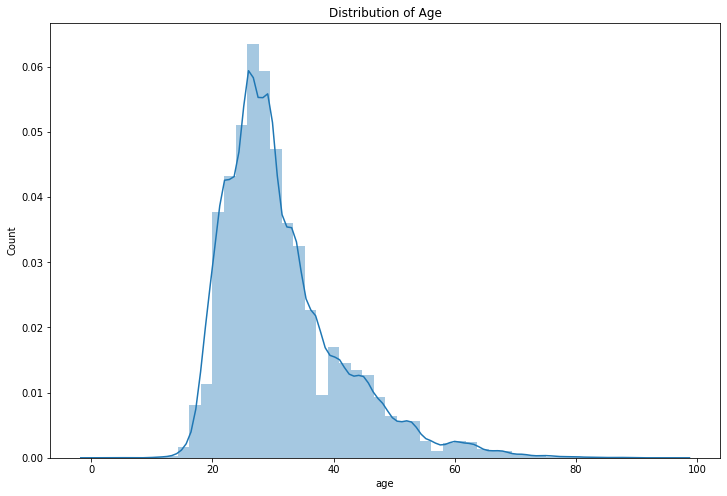

In [10]:
# Distribution of Age
fig,ax = plt.subplots(figsize=(12,8))
plt.title('Distribution of Age')
plt.xlabel('Ages')
plt.ylabel('Count')
sns.distplot(gender_age_train.age);

Looking at the graph of age distribution we can see that the most users are belonged to category of young users. 
Also the age is the only variable in entire data set that could have outlier problem. This graph show that there is no need to concern about this type of problem. I will do necessary steps for dealing with missin values in a few next steps.

In [14]:
print(gender_age_test.shape)
gender_age_test.head()

(112071, 1)


,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585
4,-5893464122623104785


The test file contains just device_id. We probably need to some merges on the files.

In [15]:
print(events.shape)
events.head()

(3252950, 5)


,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


In [16]:
print(app_events.shape)
app_events.head()

(32473067, 4)


,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


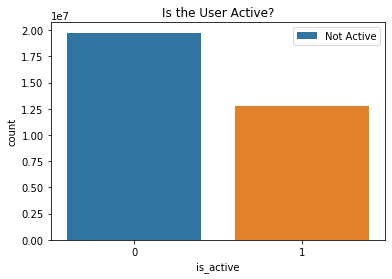

0    19740071
1    12732996
Name: is_active, dtype: int64

In [31]:
# View value counts for active users
ax = sns.countplot('is_active', data=app_events, label='Not Active')
plt.title('Is the User Active?')
ax.legend()
plt.show()
pd.value_counts(app_events['is_active'])

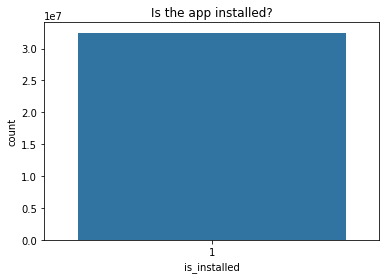

1    32473067
Name: is_installed, dtype: int64

In [36]:
# View value counts for active users
ax = sns.countplot('is_installed', data=app_events)
plt.title('Is the app installed?')
plt.show()
pd.value_counts(app_events['is_installed'])

In [40]:
print(app_labels.shape)
app_labels.head()

(459943, 2)


,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [38]:
print(app_labels.nunique())

app_id      113211
label_id       507
dtype: int64


In [19]:
print(label_categories.shape)
label_categories.head()

(930, 2)


,label_id,category
0,1,NaN
1,2,game-game type
2,3,game-Game themes
3,4,game-Art Style
4,5,game-Leisure time


In [41]:
print(label_categories.nunique())

label_id    930
category    835
dtype: int64


In [21]:
print(phone_brand_device_model.shape)
phone_brand_device_model.head()

(187245, 3)


,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


In [45]:
print(phone_brand_device_model.nunique())

device_id       186716
phone_brand        131
device_model      1599
dtype: int64


In [43]:
# Brands & model names
print('Number of distinct model names: ' + str(phone_brand_device_model.groupby(['device_model']).size().shape[0]))
print('Number of distinct brand+model names: ' + str(phone_brand_device_model.groupby(['phone_brand','device_model']).size().shape[0]))

Number of distinct model names: 1599
Number of distinct brand+model names: 1667


We need to add a new column to data set that contains a new variable which refers to each device and its brand. Then for simplifying I will encode each of them to numbers between 0 - 1666.

In [15]:
# Combine phone_brand & device_model
phone_brand_device_model['brand_and_model'] = phone_brand_device_model['phone_brand'].astype(str) + phone_brand_device_model['device_model']

# Build numerical labels for each device
model_encoder = LabelEncoder().fit(phone_brand_device_model['brand_and_model'])

# Store in a new column
phone_brand_device_model['encoded_model'] = model_encoder.transform(phone_brand_device_model['brand_and_model'])
phone_brand_device_model.head()

,device_id,phone_brand,device_model,brand_and_model,encoded_model
0,-8890648629457979026,小米,红米,小米红米,858
1,1277779817574759137,小米,MI 2,小米MI 2,843
2,5137427614288105724,三星,Galaxy S4,三星Galaxy S4,371
3,3669464369358936369,SUGAR,时尚手机,SUGAR时尚手机,166
4,-5019277647504317457,三星,Galaxy Note 2,三星Galaxy Note 2,347


# Merging Files

In [38]:
# Add active status from app_events to app_labels
apps_labeled = pd.merge(app_labels,
                       app_events[['app_id', 'is_active']],
                       on='app_id').dropna().drop_duplicates() # Drop miising values & duplicates

In [39]:
print(apps_labeled.shape)

(117374, 3)

In [47]:
apps_labeled.head()

,app_id,label_id,is_active
0,7324884708820027918,251,0
5,7324884708820027918,691,0
10,7324884708820027918,751,0
15,7324884708820027918,786,0
20,7324884708820027918,775,0


In [9]:
# Gather device_id & app_id in a dataset
device_apps = (
    app_events.merge(events, how = 'left', left_on = 'event_id', right_on = 'event_id').drop('event_id', axis = 1)
    .drop_duplicates()
)
device_apps.head()

,app_id,is_active,device_id,timestamp,longitude,latitude
0,5927333115845830913,1,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
1,-5720078949152207372,0,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,-1633887856876571208,0,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
3,-653184325010919369,1,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
4,8693964245073640147,1,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97


In [13]:
# Add device_id to train set
ga_apps = pd.merge(gender_age_train,
                  device_apps[['app_id', 'is_active', 'device_id']],
                  on='device_id').dropna().drop_duplicates()
#Shape of ga_apps
print(ga_apps.shape)

# Show how the new df looks.
ga_apps.head()

(1097150, 6)


,device_id,gender,age,group,app_id,is_active
0,-8260683887967679142,M,35,M32-38,4287147352639325907,0
1,-8260683887967679142,M,35,M32-38,-4085686983594738208,0
2,-8260683887967679142,M,35,M32-38,6324194957022958681,0
3,-8260683887967679142,M,35,M32-38,-8687507491028761317,0
4,-8260683887967679142,M,35,M32-38,877288515501232570,1


In [16]:
# Merge the previous data set with brands now. 
ga_apps_brands = pd.merge(ga_apps,
                         phone_brand_device_model[['device_id', 'encoded_model']],
                         on='device_id').dropna().drop_duplicates()
#Show me the shape
print(ga_apps_brands.shape)

#Look at how the data looks.
ga_apps_brands.head()

(1097198, 7)


,device_id,gender,age,group,app_id,is_active,encoded_model
0,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843
1,-8260683887967679142,M,35,M32-38,-4085686983594738208,0,843
2,-8260683887967679142,M,35,M32-38,6324194957022958681,0,843
3,-8260683887967679142,M,35,M32-38,-8687507491028761317,0,843
4,-8260683887967679142,M,35,M32-38,877288515501232570,1,843


In [20]:
# Putting all of the data sets together.
ga_apps_labeled_brands = pd.merge(ga_apps_brands,
                                 apps_labeled[['app_id', 'label_id']],
                                 on='app_id').dropna().drop_duplicates()
#Show me the shape
print(ga_apps_labeled_brands.shape)

#Look at how the data looks.
ga_apps_labeled_brands.head()

(7034350, 8)


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id
0,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843,713
2,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843,704
4,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843,548
6,8761770737926125955,F,22,F23-,4287147352639325907,0,226,713
8,8761770737926125955,F,22,F23-,4287147352639325907,0,226,704


Now our data set contains all intereseted variables that we need for our machone learning models. In next step I prepare the data set for the machine learning model with digitizing the variables values.

In [11]:
# Convert gender to 0 & 1
ga_apps_labeled_brands['gender'] = ga_apps_labeled_brands['gender'].apply(lambda x: 1 if x == 'M' else 0 )
print(ga_apps_labeled_brands.gender.value_counts())
ga_apps_labeled_brands.head()

1    4942697
0    2091653
Name: gender, dtype: int64


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id
0,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,713
1,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,704
2,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,548
3,8761770737926125955,0,22,F23-,4287147352639325907,0,226,713
4,8761770737926125955,0,22,F23-,4287147352639325907,0,226,704


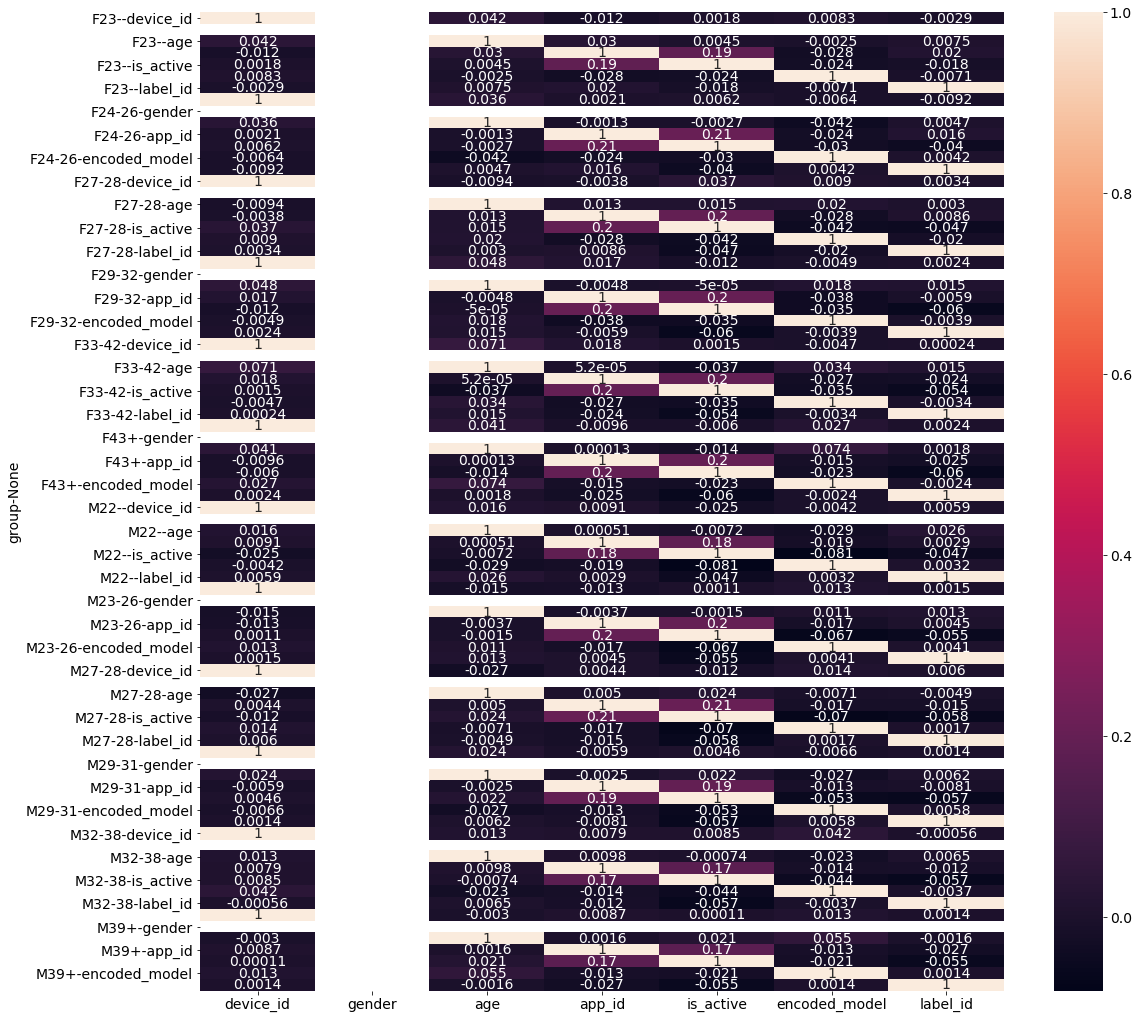

In [19]:
# Check for Multicollinearity with 10% of dtata set because actual data set is huge
df_reduct = ga_apps_labeled_brands[:700000]

# Group by group since that's the output that we care about.
df_reduct = df_reduct.groupby('group')
sns.heatmap(df_reduct.corr(), annot=True);
plt.show()

The heat map above shows that there is no significant correlation between the variabels, and low numbers are a sign of being hard to apply to machine learning models because the features in different groups don't have a strong relation.
# Creating Dummies
Two of our variables are important to be dummified, lable_id and encoded_model. Although we already reduct number of devices with combining them with their brand, but the encoded_model variable contains so many models plus brand which wout not be necessory to consider due to low correalation. So dummifying app_labels will give more insight into the data, and we use dummies for this variable.

In [36]:
print('label_id: ', ga_apps_labeled_brands.label_id.nunique())
print('encoded_model: ', ga_apps_labeled_brands.encoded_model.nunique())

label_id:  485
encoded_model:  942


In [38]:
ga_apps_labeled_brands = pd.concat([ga_apps_labeled_brands,pd.get_dummies(ga_apps_labeled_brands.label_id)], axis=1)
ga_apps_labeled_brands = ga_apps_labeled_brands.drop(columns=['label_id'], axis=1)
ga_apps_labeled_brands.head()

,device_id,gender,age,group,app_id,is_active,encoded_model,2,4,6,...,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
0,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8761770737926125955,0,22,F23-,4287147352639325907,0,226,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8761770737926125955,0,22,F23-,4287147352639325907,0,226,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Dealing with unbalanced data
Previously we saw that the data set contains significantly different persantage of men and women users. We also need to check the balance of users in each age groups.

In [39]:
# Count group values
ga_apps_labeled_brands.group.value_counts()

M32-38    1185421
M39+      1107632
M23-26     817660
M29-31     810956
M27-28     530780
F33-42     517420
M22-       490248
F43+       391188
F29-32     368450
F23-       303034
F24-26     265262
F27-28     246299
Name: group, dtype: int64

It is important to have balanced data in each group because otherwise the results of machine learning models will be influenced by dominant age groups. For this purpose an also having a smaller data set I will use down sampling method for all age groups.  

In [41]:
# Downsampling the gender/age training set
M22 = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M22-']
M23_26 = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M23-26']
M27_28 = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M27-28']
M29_31 = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M29-31']
M32_38 = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M32-38']
M39 = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M39+']
F23 = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F23-']
F24_26 = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F24-26']
F27_28 = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F27-28']
F29_32 = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F29-32']
F33_42 = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F33-42']
F43 = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F43+']

# Downsample majority classes.
M22 = resample(M22, replace=True, n_samples=50000, random_state=15)

M23_26 = resample(M23_26, replace=True, n_samples=50000, random_state=15)

M27_28 = resample(M27_28, replace=True, n_samples=50000, random_state=15)

M29_31 = resample(M29_31, replace=True, n_samples=50000, random_state=15)

M32_38 = resample(M32_38, replace=True, n_samples=50000, random_state=15)

M39 = resample(M39, replace=True, n_samples=50000, random_state=15)

F23 = resample(F23, replace=True, n_samples=50000, random_state=15)

F24_26 = resample(F24_26, replace=True, n_samples=50000, random_state=15)

F27_28 = resample(F27_28, replace=True, n_samples=50000, random_state=15)

F29_32 = resample(F29_32, replace=True, n_samples=50000, random_state=15)

F33_42 = resample(F33_42, replace=True, n_samples=50000, random_state=15)

F43 = resample(F43, replace=True, n_samples=50000, random_state=15)

In [34]:
# Display new class counts# Combine downsampled majority class 
df_resampled = pd.concat([M22, M23_26, M27_28, M29_31, M32_38, M39, 
                          F23, F24_26, F27_28, F29_32, F33_42, F43])
 
# Display new class counts
df_resampled.group.value_counts()
df_resampled.group.value_counts()

F24-26    50000
F27-28    50000
M39+      50000
M27-28    50000
F33-42    50000
F23-      50000
M29-31    50000
M32-38    50000
F29-32    50000
M22-      50000
F43+      50000
M23-26    50000
Name: group, dtype: int64

In [43]:
df_resampled.head()

,device_id,gender,age,group,app_id,is_active,encoded_model,2,4,6,...,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
3744216,-5392476162277178472,1,22,M22-,-4532036554977283654,0,1656,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6448337,-4696717825163435386,1,20,M22-,6365245642140162341,0,1654,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3751820,2633631061299877151,1,21,M22-,-4532036554977283654,0,863,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2770570,1190494768027267871,1,21,M22-,-6172775651801283024,0,1655,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2561580,-1598678751372462774,1,22,M22-,6666573792468194779,0,1655,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_resampled.dtypes

device_id     int64
gender        int64
age           int64
group        object
app_id        int64
              ...  
1017          int64
1018          int64
1019          int64
1020          int64
1021          int64
Length: 492, dtype: object

# Feature Selection & Set Train and Test

In [5]:
# Train/test set  
X = df_resampled.drop(['group'], axis=1)
y = df_resampled['group'].values

# Instantiate StandardScaler
ss = StandardScaler()

# Standarize and fit the data first 
X_stand = ss.fit_transform(X)

# Train test split
X_train, X_test, y_train, y_test = train_test_split( X_stand, y, test_size = 0.20, random_state = 1 )

# Supervised Learning Models
# Feature selection using PCA

In [18]:
# Obtain the optimal amount of components
pca = PCA(n_components=0.85)

# Fit the standarized data into it.
X_pca = pca.fit_transform(X_stand)

# Check how many components were taken 
print('Components:', X_pca.shape)

# Create a new training and testing set specifically for PCA modeling.
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split( X_pca, y, test_size = 0.20, random_state = 1 )

Components: (600000, 383)


# Naive Bayes - PCA Featuring

In [21]:
# Run Naive Bayes.
gnb = GaussianNB()
# Fit the model.
gnb.fit(X_train_pca, y_train_pca)
print(gnb)

GaussianNB(priors=None, var_smoothing=1e-09)


In [25]:
y_pred_gnb = gnb.predict(X_test_pca)
# Accuracy score.
accuracy_score(y_test_pca, y_pred_gnb)
# Cross-validation.
gnb_score = cross_val_score(gnb, X_pca, y, cv=10)
print('Cross-Validation Scores: {}'.format(gnb_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(gnb_score.mean()))
# Classification report.
print(classification_report(y_test_pca, y_pred_gnb))
# Confusion matrix.
print(confusion_matrix(y_test_pca, y_pred_gnb))

Cross-Validation Scores: [0.09126667 0.09073333 0.09391667 0.09151667 0.09685    0.09345
 0.0898     0.09281667 0.09146667 0.0909    ]
Averaged Cross-Validation Scores: 9.23%.
              precision    recall  f1-score   support

        F23-       0.14      0.04      0.06     10051
      F24-26       0.10      0.09      0.09     10099
      F27-28       0.13      0.02      0.04      9926
      F29-32       0.12      0.02      0.03     10044
      F33-42       0.10      0.00      0.00      9876
        F43+       0.09      0.89      0.16      9937
        M22-       0.13      0.02      0.03      9983
      M23-26       0.10      0.00      0.00      9840
      M27-28       0.12      0.01      0.02      9958
      M29-31       0.10      0.01      0.02     10139
      M32-38       0.11      0.01      0.01     10078
        M39+       0.13      0.01      0.02     10069

    accuracy                           0.09    120000
   macro avg       0.11      0.09      0.04    120000
weighted avg

# K-Nearest Neighbors - PCA Featuring

In [31]:
# Finding best parameters by GridSearchCV

k_range = [2,4,5,10]
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)
#print (param_grid)
knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy')
grid.fit(X_train_pca,y_train_pca)

print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.7815520833333334
{'n_neighbors': 4, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')


In [33]:
# Build the KNN model.
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')
# Fit the model.
knn.fit(X_train_pca, y_train_pca)
print(knn)
y_pred_knn = knn.predict(X_test_pca)
# Accuracy score.
accuracy_score(y_test_pca, y_pred_knn)
# Cross-validation.
knn_score = cross_val_score(knn, X_pca, y, cv=10)
print('Cross-Validation Scores: {}'.format(knn_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(knn_score.mean()))
# Classification report.
print(classification_report(y_test_pca, y_pred_knn))
# Confusion matrix.
print(confusion_matrix(y_test_pca, y_pred_knn))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')
Cross-Validation Scores: [0.80068333 0.7986     0.80048333 0.80205    0.80161667 0.80185
 0.79621667 0.79915    0.80121667 0.80165   ]
Averaged Cross-Validation Scores: 80.04%.
              precision    recall  f1-score   support

        F23-       0.91      0.85      0.88     10051
      F24-26       0.71      0.73      0.72     10099
      F27-28       0.65      0.73      0.68      9926
      F29-32       0.74      0.73      0.74     10044
      F33-42       0.88      0.83      0.85      9876
        F43+       0.95      0.94      0.94      9937
        M22-       0.88      0.86      0.87      9983
      M23-26       0.71      0.68      0.69      9840
      M27-28       0.63      0.71      0.67      9958
      M29-31       0.69      0.72      0.71     10139
      M32-38       0.83      0.79      0

# Decision Tree - PCA Featuring

In [61]:
# Finding best parameters by GridSearchCV
params = {'criterion':['gini','entropy'], 'max_features': list(range(2, 10)),
          'max_depth':[4,5,6,7,8,9,10,15,20],
          'max_leaf_nodes': [2, 10, 25, 100], 'min_samples_split': [2, 3, 4], 'random_state': [1, 5, 10, 15, 20]}
decision_tree = tree.DecisionTreeClassifier()
grid_search_cv = GridSearchCV(decision_tree, params, verbose=1, cv=3)

grid_search_cv.fit(X_train_pca, y_train_pca)

print (grid_search_cv.best_score_)
print (grid_search_cv.best_params_)
print (grid_search_cv.best_estimator_)

Fitting 3 folds for each of 8640 candidates, totalling 25920 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 25920 out of 25920 | elapsed: 363.5min finished


0.32731249999999995
{'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'max_leaf_nodes': 100, 'min_samples_split': 2, 'random_state': 20}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=9, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=20, splitter='best')


In [62]:
# Build the Decision Tree model
dtc = tree.DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=9, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=20, splitter='best')
# Fitting the model
dtc.fit(X_train_pca, y_train_pca)
print(dtc)
y_pred_dtc = dtc.predict(X_test_pca)
# Accuracy score
accuracy_score(y_test_pca, y_pred_dtc)
# Cross-validation
dtc_score = cross_val_score(dtc, X_pca, y, cv=10)
print('Cross-Validation Scores: {}'.format(dtc_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(dtc_score.mean()))
# Classification report
print(classification_report(y_test_pca, y_pred_dtc))
# Confusion matrix
print(confusion_matrix(y_test_pca, y_pred_dtc))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=9, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=20, splitter='best')
Cross-Validation Scores: [0.27103333 0.27435    0.27631667 0.26181667 0.27493333 0.27353333
 0.26216667 0.25555    0.25876667 0.26205   ]
Averaged Cross-Validation Scores: 26.71%.
              precision    recall  f1-score   support

        F23-       0.22      0.42      0.29     10051
      F24-26       0.22      0.10      0.13     10099
      F27-28       0.24      0.14      0.17      9926
      F29-32       0.25      0.18      0.21     10044
      F33-42       0.19      0.40      0.26      9876
        F43+       0.39      0.35      0.37      9937
        M22-       0.3

# Random Forest - PCA Featuring

In [67]:
# Finding best parameters by GridSearchCV
grid_rfc = RandomForestClassifier()
param_grid = {'n_estimators': [100,1000], 
              'max_depth': [5,8], 
               'max_features': [4, 8]}

grid_search_cv = GridSearchCV(grid_rfc, param_grid, verbose=1, cv=3, n_jobs=-1)
grid_search_cv.fit(X_train_pca, y_train_pca)

print (grid_search_cv.best_score_)
print (grid_search_cv.best_params_)
print (grid_search_cv.best_estimator_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 18.5min finished


0.5555833333333333
{'max_depth': 8, 'max_features': 8, 'n_estimators': 1000}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [66]:
# Building the Random Forest model
rfc = RandomForestClassifier(max_depth=8, max_features=8, n_estimators=1000, n_jobs=-1)
# Fitting the model.
rfc.fit(X_train_pca, y_train_pca)
print(rfc)
y_pred_rfc = rfc.predict(X_test_pca)
# Accuracy score
accuracy_score(y_test_pca, y_pred_rfc)
# Cross-validation
rfc_score = cross_val_score(rfc, X_pca, y, cv=10)
print('Cross-Validation Scores: {}'.format(rfc_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(rfc_score.mean()))
# Classification report
print(classification_report(y_test_pca, y_pred_rfc))
# Confusion matrix
print(confusion_matrix(y_test_pca, y_pred_rfc))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
Cross-Validation Scores: [0.54548333 0.55006667 0.55036667 0.54808333 0.54171667 0.54523333
 0.54823333 0.54568333 0.54756667 0.54801667]
Averaged Cross-Validation Scores: 54.70%.
              precision    recall  f1-score   support

        F23-       0.48      0.78      0.59     10051
      F24-26       0.45      0.27      0.34     10099
      F27-28       0.49      0.39      0.43      9926
      F29-32       0.61      0.39      0.48     10044
      F33-4

# Logistic Regression - PCA Featuring

In [17]:
# Finding best parameters by GridSearchCV
log_reg = LogisticRegression()

params = {'C':[1000,10000],
          'multi_class':['multinomial'],
          'max_iter':[100,2000],
          'penalty':['l1','l2']}

logreg_cv = GridSearchCV(log_reg, params, cv=10, n_jobs=-1)
logreg_cv.fit(X_train_pca, y_train_pca)

print (logreg_cv.best_score_)
print (logreg_cv.best_params_)
print (logreg_cv.best_estimator_)

C:\Users\Fazel\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9764583333333334
{'C': 1000, 'max_iter': 2000, 'multi_class': 'multinomial', 'penalty': 'l2'}
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [18]:
# Building the Logistic Regression model
log_reg = LogisticRegression(C=1000, max_iter=2000, multi_class='multinomial', n_jobs=-1, penalty='l2')
# Fitting the model
log_reg.fit(X_train_pca, y_train_pca)
print(log_reg)
y_pred_lr = log_reg.predict(X_test_pca)
# Accuracy score.
accuracy_score(y_test_pca, y_pred_lr)
# Cross-validation.
lr_score = cross_val_score(log_reg, X_pca, y, cv=10)
print('Cross-Validation Scores: {}'.format(lr_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(lr_score.mean()))
# Classification report.
print(classification_report(y_test_pca, y_pred_lr))
# Confusion matrix.
print(confusion_matrix(y_test_pca, y_pred_lr))

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Cross-Validation Scores: [0.98033333 0.97683333 0.98116667 0.98033333 0.981      0.98183333
 0.98       0.98116667 0.9795     0.97816667]
Averaged Cross-Validation Scores: 98.00%.
              precision    recall  f1-score   support

        F23-       0.98      0.98      0.98       987
      F24-26       0.98      0.98      0.98       991
      F27-28       0.97      0.98      0.98       980
      F29-32       0.98      0.97      0.97      1002
      F33-42       0.97      0.97      0.97       953
        F43+       0.99      0.99      0.99      1000
        M22-       0.98      0.98      0.98      1053
      M23-26       0.97      0.98      0.98      1048


# Support Vector Machine - PCA Featuring

In [10]:
# Normalization on standardized data
X_norm = preprocessing.normalize(X_stand)

# Fit the normalized data into pca
X_pca = pca.fit_transform(X_norm)

# Create a new training and testing set specifically for PCA modeling.
X_train_pca_n, X_test_pca_n, y_train_pca_n, y_test_pca_n = train_test_split( X_pca, y, test_size = 0.20, random_state = 1 )

In [11]:
# Finding best parameters by GridSearchCV
svc = LinearSVC()

Cs = [0.1, 1, 10, 100]
param_grid = {'C': Cs, 'max_iter' : [1000, 5000, 10000]}

grid_search_cv = GridSearchCV(svc, param_grid, n_jobs=-1, cv=5)
grid_search_cv.fit(X_train_pca, y_train_pca)

print (grid_search_cv.best_score_)
print (grid_search_cv.best_params_)
print (grid_search_cv.best_estimator_)

0.5265196078431372
{'C': 10, 'max_iter': 1000}
LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


In [12]:
# Building the SVM model
svc = LinearSVC(C=10, max_iter=1000)
# Fitting the model
svc.fit(X_train_pca_n, y_train_pca_n)
print(svc)
y_pred_svc = svc.predict(X_test_pca_n)
# Accuracy score
accuracy_score(y_test_pca_n, y_pred_svc)
# Cross-validation
svc_score = cross_val_score(svc, X_pca_n, y, cv=10)
print('Cross-Validation Scores: {}'.format(svc_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(svc_score.mean()))
# Classification score
print(classification_report(y_test_pca_n, y_pred_svc))
# Confusion matrix
print(confusion_matrix(y_test_pca_n, y_pred_svc))

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Cross-Validation Scores: [0.52323529 0.52039216 0.52470588 0.52901961 0.51990196 0.52686275
 0.52254902 0.51794118 0.52284314 0.52666667]
Averaged Cross-Validation Scores: 52.34%.
              precision    recall  f1-score   support

        F23-       0.59      0.88      0.70      1699
      F24-26       0.31      0.36      0.34      1673
      F27-28       0.40      0.25      0.31      1764
      F29-32       0.52      0.33      0.40      1637
      F33-42       0.61      0.42      0.50      1685
        F43+       0.64      0.90      0.75      1663
        M22-       0.57      0.87      0.69      1682
      M23-26       0.35      0.36      0.35      1732
      M27-28       0.43      0.28      0.34      1767
      M29-31       0.52      0.34      0.41      1

# Feature selection using SelectKBest

In [34]:
# Encode groups for preparing to fit SelectKBest
# Build numerical labels for target groups
model_encoder = LabelEncoder().fit(df_resampled['group'])

# Store in a new column
df_resampled['encoded_group'] = model_encoder.transform(df_resampled['group'])
df_resampled()

,device_id,gender,age,group,app_id,is_active,encoded_model,2,4,6,...,1013,1014,1015,1016,1017,1018,1019,1020,1021,encoded_group
0,-243186812835285661,1,22,M22-,33792862810792679,1,865,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1,3042999840186016499,1,20,M22-,-7509752927626140732,0,128,0,0,0,...,0,0,0,0,0,0,0,0,0,6
2,-9024646837768278604,1,22,M22-,-7377705850326369447,0,847,0,0,0,...,0,0,0,0,0,0,0,0,0,6
3,4760257368378545414,1,20,M22-,2022530832075009460,0,848,0,0,0,...,0,0,0,0,0,0,0,0,0,6
4,7690261349530060632,1,21,M22-,-923192824907939817,0,846,0,0,0,...,0,0,0,0,0,0,0,0,0,6


In [35]:
Y = df_resampled['encoded_group'].values

In [37]:
# Select top 100 features
selection = SelectKBest(score_func=f_regression, k=100) 
X_kbest = selection.fit_transform(X_stand, Y)


C:\Users\Fazel\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Fazel\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Fazel\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Fazel\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [43]:
# Create a new training and testing set specifically for SelectBestK featuring.
X_train_kbest, X_test_kbest, y_train_kbest, y_test_kbest = train_test_split( X_kbest, y, test_size = 0.20, random_state = 1 )

# Naive Bayes - SelectKBest Featuring

In [49]:
# Run Naive Bayes.
gnb = GaussianNB()
time_start = perf_counter()
# Fit the model
gnb.fit(X_train_kbest, y_train_kbest)
time_elapsed = (perf_counter() - time_start)
print(gnb)
print('Running time: ', time_elapsed)

GaussianNB(priors=None, var_smoothing=1e-09)
Running time:  0.6707760849994884


In [50]:
y_pred_gnb = gnb.predict(X_test_kbest)
# Accuracy score.
accuracy_score(y_test_kbest, y_pred_gnb)
# Cross-validation.
gnb_score = cross_val_score(gnb, X_kbest, y, cv=10)
print('Cross-Validation Scores: {}'.format(gnb_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(gnb_score.mean()))
# Classification report.
print(classification_report(y_test_kbest, y_pred_gnb))
# Confusion matrix.
print(confusion_matrix(y_test_kbest, y_pred_gnb))

Cross-Validation Scores: [0.34313725 0.3195098  0.27676471 0.32254902 0.26980392 0.27196078
 0.25470588 0.38264706 0.30264706 0.26029412]
Averaged Cross-Validation Scores: 30.04%.
              precision    recall  f1-score   support

        F23-       0.47      0.12      0.19      1699
      F24-26       0.41      0.02      0.04      1673
      F27-28       0.58      0.11      0.19      1764
      F29-32       0.22      0.01      0.01      1637
      F33-42       0.21      0.85      0.33      1685
        F43+       0.46      0.62      0.53      1663
        M22-       0.43      0.05      0.08      1682
      M23-26       0.30      0.92      0.45      1732
      M27-28       0.00      0.00      0.00      1767
      M29-31       0.47      0.62      0.54      1719
      M32-38       0.25      0.02      0.03      1701
        M39+       0.65      0.95      0.78      1678

    accuracy                           0.36     20400
   macro avg       0.37      0.36      0.26     20400
weighted

# K-Nearest Neighbors - SelectKBest Featuring

In [31]:
# Finding best parameters by GridSearchCV

k_range = [2,4,5,10]
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)
#print (param_grid)
knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy')
grid.fit(X_train_kbest,y_train_kbest)

print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.7815520833333334
{'n_neighbors': 4, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')


In [55]:
# Build the KNN model.
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')
time_start = perf_counter()
# Fit the model.
knn.fit(X_train_kbest, y_train_kbest)
time_elapsed = (perf_counter() - time_start)
print(knn)
print('Running time: ', time_elapsed)
y_pred_knn = knn.predict(X_test_kbest)
# Accuracy score.
accuracy_score(y_test_kbest, y_pred_knn)
# Cross-validation.
knn_score = cross_val_score(knn, X_kbest, y, cv=10)
print('Cross-Validation Scores: {}'.format(knn_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(knn_score.mean()))
# Classification report.
print(classification_report(y_test_kbest, y_pred_knn))
# Confusion matrix.
print(confusion_matrix(y_test_kbest, y_pred_knn))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')
Running time:  79.35574454299967
Cross-Validation Scores: [0.85029412 0.85107843 0.85176471 0.85490196 0.85568627 0.85147059
 0.84941176 0.85313725 0.85009804 0.84784314]
Averaged Cross-Validation Scores: 85.16%.
              precision    recall  f1-score   support

        F23-       0.92      0.86      0.89      1699
      F24-26       0.76      0.80      0.78      1673
      F27-28       0.75      0.79      0.77      1764
      F29-32       0.79      0.81      0.80      1637
      F33-42       0.90      0.86      0.88      1685
        F43+       0.95      0.95      0.95      1663
        M22-       0.90      0.90      0.90      1682
      M23-26       0.80      0.75      0.77      1732
      M27-28       0.72      0.80      0.76      1767
      M29-31       0.77      0.81      0.79      1719
      

# Decision Tree - SelectKBest Featuring

In [61]:
# Finding best parameters by GridSearchCV
params = {'criterion':['gini','entropy'], 'max_features': list(range(2, 10)),
          'max_depth':[4,5,6,7,8,9,10,15,20],
          'max_leaf_nodes': [2, 10, 25, 100], 'min_samples_split': [2, 3, 4], 'random_state': [1, 5, 10, 15, 20]}
decision_tree = tree.DecisionTreeClassifier()
grid_search_cv = GridSearchCV(decision_tree, params, verbose=1, cv=3)

grid_search_cv.fit(X_train_kbest, y_train_kbest)

print (grid_search_cv.best_score_)
print (grid_search_cv.best_params_)
print (grid_search_cv.best_estimator_)

Fitting 3 folds for each of 8640 candidates, totalling 25920 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 25920 out of 25920 | elapsed: 363.5min finished


0.32731249999999995
{'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'max_leaf_nodes': 100, 'min_samples_split': 2, 'random_state': 20}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=9, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=20, splitter='best')


In [64]:
# Build the Decision Tree model
dtc = tree.DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=9, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=20, splitter='best')
time_start = perf_counter()
# Fitting the model
dtc.fit(X_train_kbest, y_train_kbest)
time_elapsed = (perf_counter() - time_start)
print(dtc)
print('Running time: ', time_elapsed)

y_pred_dtc = dtc.predict(X_test_kbest)
# Accuracy score
accuracy_score(y_test_kbest, y_pred_dtc)
# Cross-validation
dtc_score = cross_val_score(dtc, X_kbest, y, cv=10)
print('Cross-Validation Scores: {}'.format(dtc_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(dtc_score.mean()))
# Classification report
print(classification_report(y_test_kbest, y_pred_dtc))
# Confusion matrix
print(confusion_matrix(y_test_kbest, y_pred_dtc))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=9, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=20, splitter='best')
Running time:  0.5988214769968181
Cross-Validation Scores: [0.34235294 0.37205882 0.49823529 0.44137255 0.38186275 0.43696078
 0.28931373 0.32186275 0.42529412 0.34627451]
Averaged Cross-Validation Scores: 38.56%.
              precision    recall  f1-score   support

        F23-       0.67      0.04      0.08      1699
      F24-26       0.50      0.98      0.66      1673
      F27-28       0.21      0.26      0.23      1764
      F29-32       0.26      0.21      0.23      1637
      F33-42       0.28      0.25      0.26      1685
        F43+       0.12      0.00      0.0

In [67]:
# Finding best parameters by GridSearchCV
grid_rfc = RandomForestClassifier()
param_grid = {'n_estimators': [100,1000], 
              'max_depth': [5,8], 
               'max_features': [4, 8]}

grid_search_cv = GridSearchCV(grid_rfc, param_grid, verbose=1, cv=3, n_jobs=-1)
grid_search_cv.fit(X_train_kbest, y_train_kbest)

print (grid_search_cv.best_score_)
print (grid_search_cv.best_params_)
print (grid_search_cv.best_estimator_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 18.5min finished


0.5555833333333333
{'max_depth': 8, 'max_features': 8, 'n_estimators': 1000}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [68]:
# Building the Random Forest model
rfc = RandomForestClassifier(max_depth=8, max_features=8, n_estimators=1000, n_jobs=-1)
time_start = perf_counter()
# Fitting the model.
rfc.fit(X_train_kbest, y_train_kbest)
time_elapsed = (perf_counter() - time_start)
print(rfc)
print('Running time: ', time_elapsed)

y_pred_rfc = rfc.predict(X_test_kbest)
# Accuracy score
accuracy_score(y_test_kbest, y_pred_rfc)
# Cross-validation
rfc_score = cross_val_score(rfc, X_kbest, y, cv=10)
print('Cross-Validation Scores: {}'.format(rfc_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(rfc_score.mean()))
# Classification report
print(classification_report(y_test_kbest, y_pred_rfc))
# Confusion matrix
print(confusion_matrix(y_test_kbest, y_pred_rfc))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
Running time:  75.13701524900534
Cross-Validation Scores: [0.9995098  0.99764706 0.99882353 0.99705882 0.99735294 0.99539216
 0.99901961 0.99686275 0.99656863 0.99754902]
Averaged Cross-Validation Scores: 99.76%.
              precision    recall  f1-score   support

        F23-       1.00      1.00      1.00      1699
      F24-26       1.00      1.00      1.00      1673
      F27-28       1.00      1.00      1.00      1764
      F29-32       0.99      1.0

# Logistic Regression - SelectKBest Featuring

In [70]:
# Finding best parameters by GridSearchCV
log_reg = LogisticRegression()

params = {'C':[1000,10000],
          'multi_class':['multinomial'],
          'max_iter':[100,2000],
          'penalty':['l1','l2']}

logreg_cv = GridSearchCV(log_reg, params, cv=10, n_jobs=-1)
logreg_cv.fit(X_train_kbest, y_train_kbest)

print (logreg_cv.best_score_)
print (logreg_cv.best_params_)
print (logreg_cv.best_estimator_)

0.9997916666666666
{'C': 10000, 'max_iter': 2000, 'multi_class': 'multinomial', 'penalty': 'l2'}
LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [71]:
# Building the Logistic Regression model
log_reg = LogisticRegression(C=10000, max_iter=2000, multi_class='multinomial', n_jobs=-1, penalty='l2')
time_start = perf_counter()
# Fitting the model
log_reg.fit(X_train_kbest, y_train_kbest)
time_elapsed = (perf_counter() - time_start)
print(log_reg)
print('Running time: ', time_elapsed)

y_pred_lr = log_reg.predict(X_test_kbest)
# Accuracy score.
accuracy_score(y_test_kbest, y_pred_lr)
# Cross-validation.
lr_score = cross_val_score(log_reg, X_kbest, y, cv=10)
print('Cross-Validation Scores: {}'.format(lr_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(lr_score.mean()))
# Classification report.
print(classification_report(y_test_kbest, y_pred_lr))
# Confusion matrix.
print(confusion_matrix(y_test_kbest, y_pred_lr))

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Running time:  925.9497730319999
Cross-Validation Scores: [0.99990196 0.99990196 0.99990196 1.         1.         0.99970588
 0.99980392 0.99970588 0.99980392 0.99980392]
Averaged Cross-Validation Scores: 99.99%.
              precision    recall  f1-score   support

        F23-       1.00      1.00      1.00      1699
      F24-26       1.00      1.00      1.00      1673
      F27-28       1.00      1.00      1.00      1764
      F29-32       1.00      1.00      1.00      1637
      F33-42       1.00      1.00      1.00      1685
        F43+       1.00      1.00      1.00      1663
        M22-       1.00      1.00      1.00      1682
      M23-26       1

# Support Vector Machine - SelectKBest Featuring

In [76]:
# Normalization
X_norm = preprocessing.normalize(X_stand)

# Select top 100 features
selection = SelectKBest(score_func=f_regression, k=100) 
X_kbest_n = selection.fit_transform(X_norm, Y)

# Create a new training and testing set specifically for SelectBestK featuring.
X_train_kbest_n, X_test_kbest_n, y_train_kbest_n, y_test_kbest_n = train_test_split( X_kbest_n, y, test_size = 0.20, random_state = 1 )

In [80]:
# Finding best parameters by GridSearchCV
svc = LinearSVC()

Cs = [0.1, 1, 10, 100]
param_grid = {'C': Cs, 'max_iter' : [1000, 5000, 10000]}

grid_search_cv = GridSearchCV(svc, param_grid, n_jobs=-1, cv=5)
grid_search_cv.fit(X_train_kbest, y_train_kbest)

print (grid_search_cv.best_score_)
print (grid_search_cv.best_params_)
print (grid_search_cv.best_estimator_)

0.6455514705882353
{'C': 10, 'max_iter': 1000}
LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


C:\Users\Fazel\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [83]:
# Building the SVM model
svc = LinearSVC(C=10, max_iter=1000)
time_start = perf_counter()
# Fitting the model
svc.fit(X_train_kbest_n, y_train_kbest_n)
time_elapsed = (perf_counter() - time_start) 
print(svc)
print('Running time: ', time_elapsed)

y_pred_svc = svc.predict(X_test_kbest_n)
# Accuracy score
accuracy_score(y_test_kbest_n, y_pred_svc)
# Cross-validation
svc_score = cross_val_score(svc, X_kbest_n, y, cv=10)
print('Cross-Validation Scores: {}'.format(svc_score))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(svc_score.mean()))
# Classification score
print(classification_report(y_test_kbest_n, y_pred_svc))
# Confusion matrix
print(confusion_matrix(y_test_kbest_n, y_pred_svc))

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Running time:  346.62868175400945
Cross-Validation Scores: [0.51509804 0.51205882 0.52117647 0.52058824 0.51323529 0.52323529
 0.51676471 0.51686275 0.52009804 0.51715686]
Averaged Cross-Validation Scores: 51.76%.
              precision    recall  f1-score   support

        F23-       0.57      0.87      0.69      1699
      F24-26       0.33      0.40      0.36      1673
      F27-28       0.41      0.26      0.32      1764
      F29-32       0.58      0.31      0.40      1637
      F33-42       0.61      0.40      0.48      1685
        F43+       0.64      0.91      0.75      1663
        M22-       0.56      0.87      0.68      1682
      M23-26       0.35      0.36      0.35      1732
      M27-28       0.42      0.28      0.34      1767
      M29-31    

# Convolutional Neural Network

In [1]:
# Initializing again due to shutting down previous kernel
# Load necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression

In [17]:
import tensorflow as tf
import keras

# Import various componenets tensor felow for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, MaxoutDense
from keras.models import Model
from keras.preprocessing import sequence
from keras.optimizers import RMSprop, Adam, SGD, Adagrad
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization

# Import the backend
from keras import backend as K

Using TensorFlow backend.


### SelectKBest Featuring

In [12]:
# Read the saved date
df_resampled = pd.read_csv("df_resampled.csv")

# Train/test set  
X = df_resampled.drop(['group', 'encoded_group'], axis=1)
y = df_resampled['encoded_group'].values

# Instantiate StandardScaler
ss = StandardScaler()

# Standarize and fit the data first 
X_stand = ss.fit_transform(X)
# Select top 100 features
selection = SelectKBest(score_func=f_regression, k=100) 
X_kbest = selection.fit_transform(X_stand, y)

# Create a new training and testing set specifically for SelectBestK featuring.
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split( X_kbest, y, test_size = 0.20, random_state = 1 )

c:\users\fazel\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
c:\users\fazel\anaconda3\envs\tensorflow_env\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\fazel\anaconda3\envs\tensorflow_env\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\fazel\anaconda3\envs\tensorflow_env\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [18]:
# Modify the dimension input and target variables for Conv1d
X_train_CNN = np.expand_dims(X_train_tf, axis=2)
X_test_CNN = np.expand_dims(X_test_tf, axis=2)

# Encode y into 12 different vectors for CNN because of our 12 age groups
y_train_CNN = np_utils.to_categorical(y_train_tf, 12)
y_test_CNN = np_utils.to_categorical(y_test_tf, 12)

In [19]:
# Building the Convolutionals Model
model = Sequential()

# Set up some parameters
input_dim = 1

# Convert X_train and X_test to numpy array and check lenths to be equal
max_review_length = 500 
X_train_CNN_f = sequence.pad_sequences(X_train_CNN, maxlen=max_review_length) 
X_test_CNN_f = sequence.pad_sequences(X_test_CNN, maxlen=max_review_length)


# First convolutional layer
model.add(Conv1D(64, kernel_size=10,
                 padding='same',
                 input_shape=(max_review_length, input_dim),
                 activation='elu',
                 strides=1))
model.add(Conv1D(64, kernel_size=20, activation='elu'))
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=15, activation='elu'))
model.add(MaxPooling1D(pool_size=15,
                       padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv1D(32, kernel_size=20, activation='elu'))
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=10, activation='elu'))
model.add(MaxPooling1D(pool_size=25,
                       padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(MaxoutDense(32, nb_feature=12))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxoutDense(32, nb_feature=12))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(MaxoutDense(32, nb_feature=12))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adagrad(),
              metrics=['accuracy'])

model.summary()

c:\users\fazel\anaconda3\envs\tensorflow_env\lib\site-packages\keras\legacy\layers.py:74: UserWarning: The `MaxoutDense` layer is deprecated and will be removed after 06/2017.
  warnings.warn('The `MaxoutDense` layer is deprecated '


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 500, 64)           704       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 481, 64)           81984     
_________________________________________________________________
batch_normalization_1 (Batch (None, 481, 64)           256       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 467, 32)           30752     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 32)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32)            128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32)           

In [22]:
model.fit(X_train_CNN_f, y_train_CNN,
          batch_size=1250,
          epochs=10,
          verbose=1,
          validation_data=(X_test_CNN_f, y_test_CNN))

score = model.evaluate(X_test_CNN_f, y_test_CNN, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 81600 samples, validate on 20400 samples
Epoch 1/10
81600/81600 [==============================] - 2645s 32ms/step - loss: 2.2692 - accuracy: 0.1883 - val_loss: 2.3205 - val_accuracy: 0.1618
Epoch 2/10
81600/81600 [==============================] - 2707s 33ms/step - loss: 1.7325 - accuracy: 0.3246 - val_loss: 2.8843 - val_accuracy: 0.0824
Epoch 3/10
81600/81600 [==============================] - 2748s 34ms/step - loss: 1.5324 - accuracy: 0.3749 - val_loss: 3.8847 - val_accuracy: 0.0943
Epoch 4/10
81600/81600 [==============================] - 2748s 34ms/step - loss: 1.4493 - accuracy: 0.3911 - val_loss: 7.7605 - val_accuracy: 0.1278
Epoch 5/10
81600/81600 [==============================] - 2749s 34ms/step - loss: 1.4055 - accuracy: 0.3984 - val_loss: 11.2341 - val_accuracy: 0.1290
Epoch 6/10
81600/81600 [==============================] - 2750s 34ms/step - loss: 1.3740 - accuracy: 0.4047 - val_loss: 13.3941 - val_accuracy: 0.1289
Epoch 7/10
81600/81600 [========================

### PCA Featuring

In [24]:
# Obtain the optimal amount of components
pca = PCA(n_components=0.85)

# Fit the standarized data into it.
X_pca = pca.fit_transform(X_stand)

# Create a new training and testing set specifically for PCA modeling.
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split( X_pca, y, test_size = 0.20, random_state = 1 )

In [26]:
# Modify the dimension input and target variables for Conv1d
X_train_CNN = np.expand_dims(X_train_pca, axis=2)
X_test_CNN = np.expand_dims(X_test_pca, axis=2)

# Encode y into 12 different vectors for CNN because of our 12 age groups
y_train_CNN = np_utils.to_categorical(y_train_pca, 12)
y_test_CNN = np_utils.to_categorical(y_test_pca, 12)

In [27]:
# Building the Convolutionals Model
model = Sequential()

# Set up some parameters
input_dim = 1

# Convert X_train and X_test to numpy array and check lenths to be equal
max_review_length = 500 
X_train_CNN_f = sequence.pad_sequences(X_train_CNN, maxlen=max_review_length) 
X_test_CNN_f = sequence.pad_sequences(X_test_CNN, maxlen=max_review_length)


# First convolutional layer
model.add(Conv1D(64, kernel_size=10,
                 padding='same',
                 input_shape=(max_review_length, input_dim),
                 activation='elu',
                 strides=1))
model.add(Conv1D(64, kernel_size=20, activation='elu'))
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=15, activation='elu'))
model.add(MaxPooling1D(pool_size=15,
                       padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv1D(32, kernel_size=20, activation='elu'))
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=10, activation='elu'))
model.add(MaxPooling1D(pool_size=25,
                       padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(MaxoutDense(32, nb_feature=12))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxoutDense(32, nb_feature=12))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(MaxoutDense(32, nb_feature=12))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adagrad(),
              metrics=['accuracy'])

model.summary()

c:\users\fazel\anaconda3\envs\tensorflow_env\lib\site-packages\keras\legacy\layers.py:74: UserWarning: The `MaxoutDense` layer is deprecated and will be removed after 06/2017.
  warnings.warn('The `MaxoutDense` layer is deprecated '


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 500, 64)           704       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 481, 64)           81984     
_________________________________________________________________
batch_normalization_8 (Batch (None, 481, 64)           256       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 467, 32)           30752     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 32, 32)            0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32)            128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32)           

In [28]:
model.fit(X_train_CNN_f, y_train_CNN,
          batch_size=1250,
          epochs=10,
          verbose=1,
          validation_data=(X_test_CNN_f, y_test_CNN))

score = model.evaluate(X_test_CNN_f, y_test_CNN, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 81600 samples, validate on 20400 samples
Epoch 1/10
81600/81600 [==============================] - 2863s 35ms/step - loss: 2.6156 - accuracy: 0.0839 - val_loss: 2.4971 - val_accuracy: 0.0820
Epoch 2/10
81600/81600 [==============================] - 2612s 32ms/step - loss: 2.5691 - accuracy: 0.0857 - val_loss: 2.4881 - val_accuracy: 0.0925
Epoch 3/10
81600/81600 [==============================] - 2612s 32ms/step - loss: 2.5683 - accuracy: 0.0848 - val_loss: 2.4878 - val_accuracy: 0.0947
Epoch 4/10
81600/81600 [==============================] - 2600s 32ms/step - loss: 2.5532 - accuracy: 0.0863 - val_loss: 2.4883 - val_accuracy: 0.0892
Epoch 5/10
81600/81600 [==============================] - 2607s 32ms/step - loss: 2.5505 - accuracy: 0.0844 - val_loss: 2.4887 - val_accuracy: 0.0932
Epoch 6/10
81600/81600 [==============================] - 2615s 32ms/step - loss: 2.5448 - accuracy: 0.0862 - val_loss: 2.4871 - val_accuracy: 0.0898
Epoch 7/10
81600/81600 [==========================

# Unsupervised Lerning Models

Becausse clustering is usually done using a distance measure between samples, and many approaches  assume that the clusters share certain properties, balanced data will be used for the unsupervised learning models to avoid problems of unbalanced data.

In [1]:
# Load necessory libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

In [10]:
# Load saved resampled data with 8500 samples for each age group
# because for 70000 samples for each group and a data set with th 
# shape of (840000, 492) I got the error of memory
# "MemoryError: Unable to allocate 3.07 GiB for an array with shape (840000, 491) and data type float64"

df = pd.read_csv('df_resampled.csv')
df.head()

,device_id,gender,age,group,app_id,is_active,encoded_model,2,4,6,...,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
0,-243186812835285661,1,22,M22-,33792862810792679,1,865,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3042999840186016499,1,20,M22-,-7509752927626140732,0,128,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-9024646837768278604,1,22,M22-,-7377705850326369447,0,847,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4760257368378545414,1,20,M22-,2022530832075009460,0,848,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7690261349530060632,1,21,M22-,-923192824907939817,0,846,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df.shape

(102000, 492)

# K-means
Set Input Variables and find the best number of clusters

In [12]:
# Set input
X = df.drop(['group'], axis=1)

# Standarizing the features
ss = StandardScaler()
X_std = ss.fit_transform(X)

In [13]:
# Find silhoutte scores for the range of 2 to 12 clusters
for n in range(2,5):
    clusters = KMeans(n_clusters=n, random_state=123)
    preds = clusters.fit_predict(X_std)
    score = silhouette_score (X_std, preds, metric='euclidean')
    print ("For n_clusters = {}, silhoutte score is {}".format(n, score))

For n_clusters = 2, silhoutte score is 0.014025507278099888
For n_clusters = 3, silhoutte score is -0.00894584351789801
For n_clusters = 4, silhoutte score is -0.008443140225703792
